# Experiments with water normalization

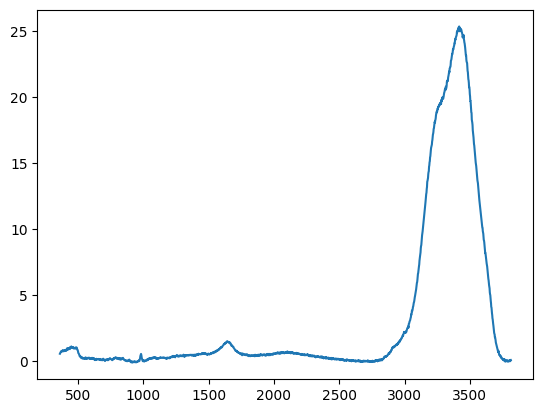

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Load pure water
x_axis_water = []
values_water = []
with open('sea_water_mean.txt') as pure_spectrum:
    for line in pure_spectrum:
        x, val = line.split()
        x_axis_water.append(float(x))
        values_water.append(float(val))

plt.plot(x_axis_water, values_water)
plt.show()

In [27]:
import scipy

# load .mat data with expected structure
in_file = '../data/Gefionella.mat'
mdict = {}
matlab_data = scipy.io.loadmat(in_file, mdict=mdict)

name = list(mdict)[-1]
matlab_data = matlab_data[name][0, 0]

data = matlab_data[7]

map_shape = tuple(matlab_data[5][0])

x_axis = matlab_data[9][1][0][0]
# data = np.reshape(data, (map_shape[1], map_shape[0], -1))
print(data.shape)

(1200, 1600)


/home/filip/.local/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


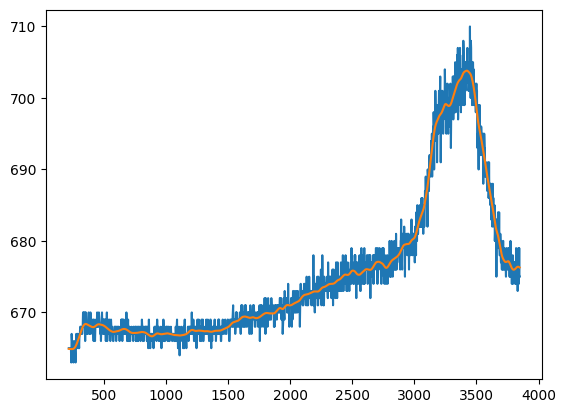

In [28]:
# Loaded data smoothing

from scipy import sparse
lam = 1600
def whittaker(y,lmd = lam, d = 2):
    #lmd: smoothing parameter lamda,
    #the suggested value of lamda = 1600 seems way to much for Raman spectra
    #d: order of differences in penalty (2)
    L = len(y)
    E = sparse.csc_matrix(np.diff(np.eye(L), d))
    W = sparse.spdiags(np.ones(L), 0, L, L)
    Z = W + lmd * E.dot(E.transpose())
    z = sparse.linalg.spsolve(Z, np.ones(L)*y)
    return z

def whittaker_vectorized(Y, lmd=lam, d=2):
    if Y.ndim != 2:
        raise ValueError("Input must be a 2D array")

    num_spectra, L = Y.shape
    E = sparse.csc_matrix(np.diff(np.eye(L), d))
    W = sparse.spdiags(np.ones(L), 0, L, L)
    Z = W + lmd * E.dot(E.transpose())

    # Pre-factorize Z for efficiency
    Z_inv = sparse.linalg.factorized(Z)

    # Solve for each spectrum (each row in Y)
    smoothed_data = np.array([Z_inv(Y[i, :]) for i in range(num_spectra)])

    return smoothed_data

smoothed_data = whittaker_vectorized(data)
plt.plot(x_axis, data[323])
plt.plot(x_axis, smoothed_data[323])
plt.show()


0


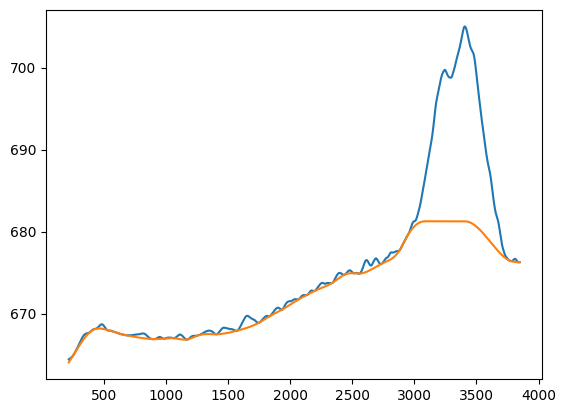

100


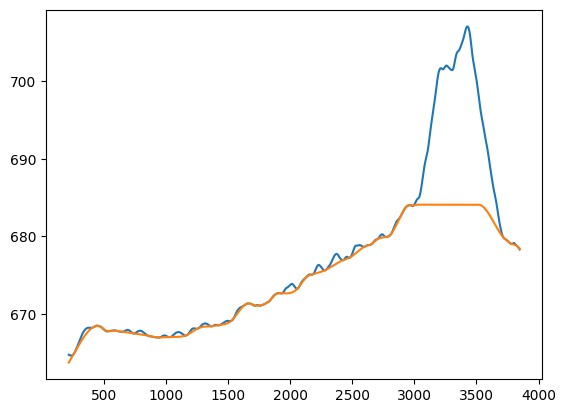

200


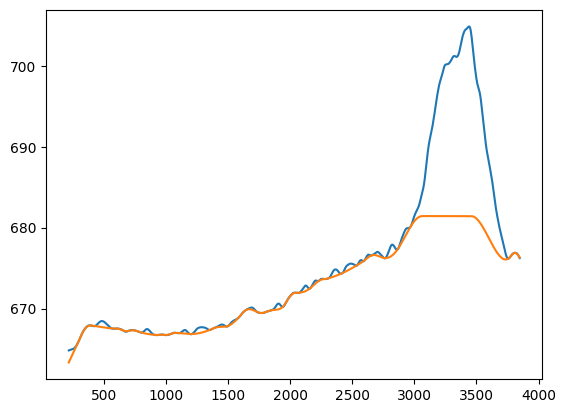

300


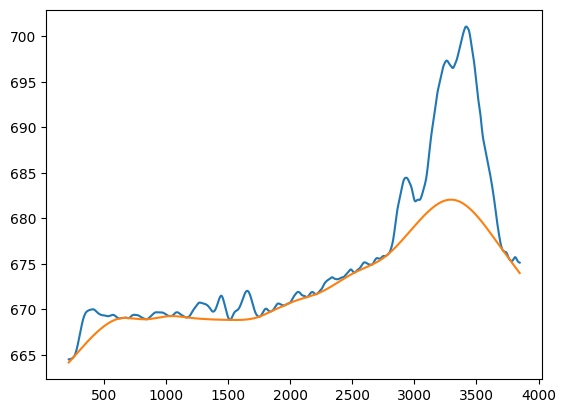

400


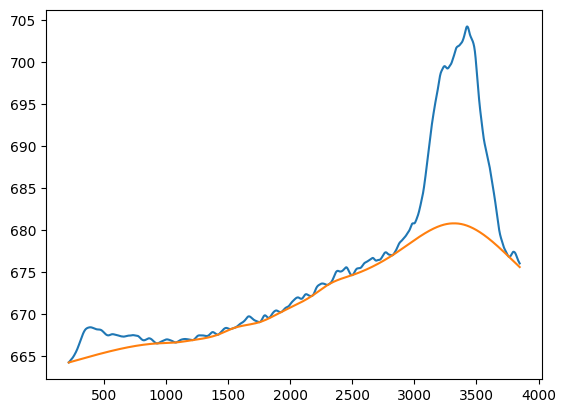

500


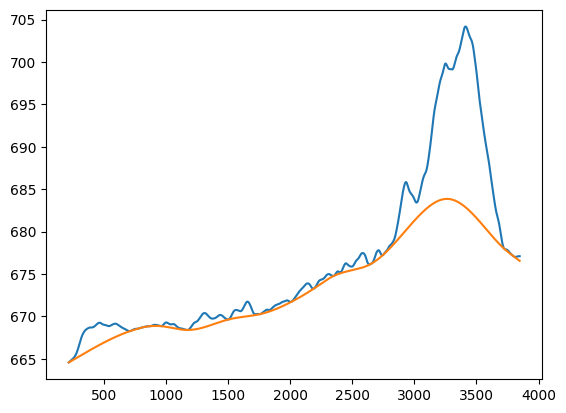

600


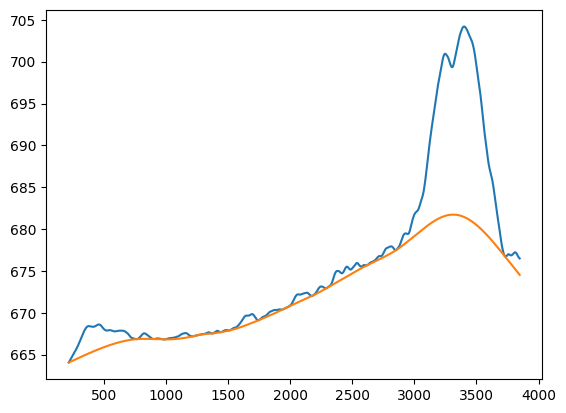

700


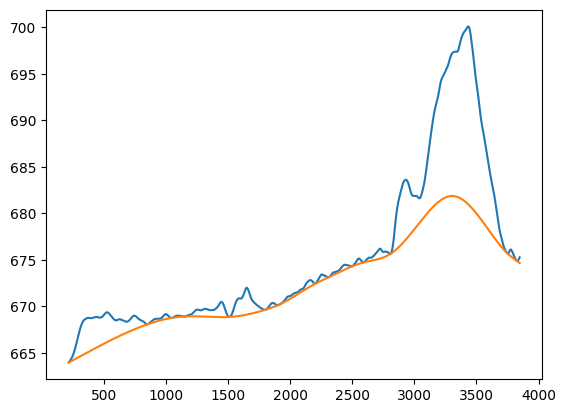

800


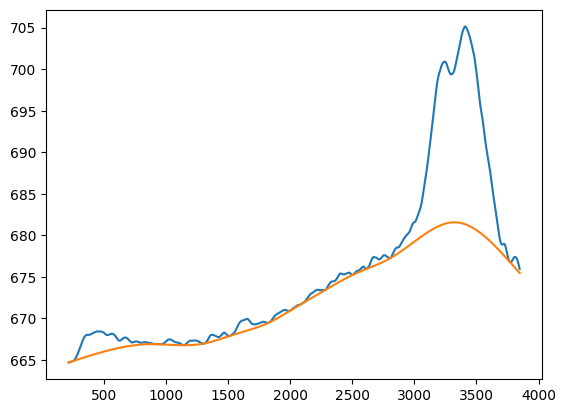

900


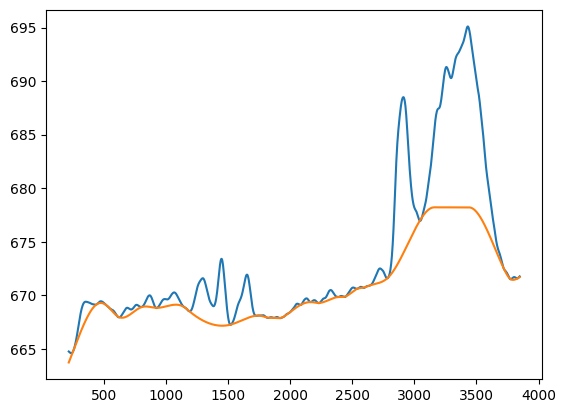

1000


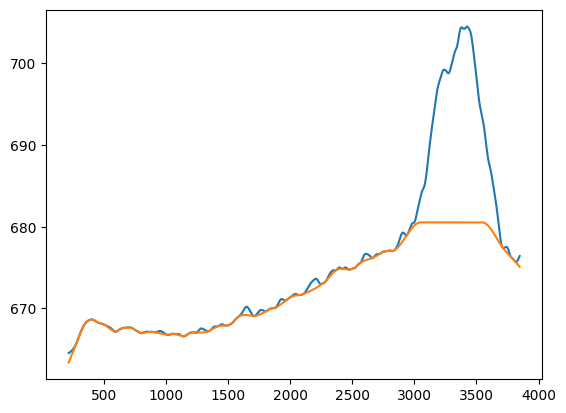

1100


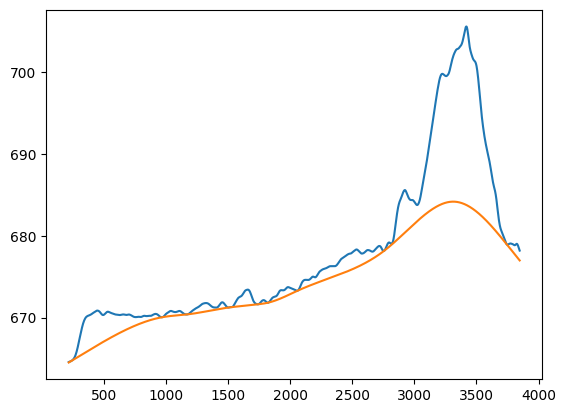

(1200, 1600)


In [29]:
# remove baseline
import numpy as np                                      #for several calculations
import matplotlib.pyplot as plt                         #for plots
from scipy import sparse                                #for arPLS and Whittaker
from scipy.sparse import linalg                         #for arPLS and Whittaker
from scipy.special import expit                         #for arPLS
from scipy import sparse
import copy


arpls_ratio = 1e-6                          #ratio for arPLS
lam = 1000                                  #lamda for the arPLS baseline correction
n_iter = 200    

def baseline_arPLS(y, ratio=arpls_ratio, lam=lam, niter=n_iter):
    L = len(y)    
    diag = np.ones(L - 2)
    D = sparse.spdiags([diag, -2*diag, diag], [0, -1, -2], L, L - 2)    
    H = lam * D.dot(D.T)     
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)    
    crit = 1
    count = 0    
    while crit > ratio:
        z = linalg.spsolve(W + H, W * y)
        d = y - z
        dn = d[d < 0]        
        m = np.mean(dn)
        s = np.std(dn)        
        w_new = expit(-2 * (d - (2*s - m))/s)
        crit = np.linalg.norm(w_new - w) / np.linalg.norm(w)        
        w = w_new
        W.setdiag(w)         
        count += 1        
        if count > niter:
            break
    return z

new_data = []
for i, spectrum in enumerate(smoothed_data):

    # 3000, 3700
    left_val = np.argmin(np.abs(x_axis - 3000))
    right_val = np.argmin(np.abs(x_axis - 3700))
    spectrum_orig = copy.deepcopy(spectrum)
    spectrum[left_val: right_val] = spectrum[left_val]
    bg = baseline_arPLS(spectrum,lam=lam)
    spectrum = spectrum_orig

    if i % 100 == 0:
        print(i)
        plt.plot(x_axis, spectrum)
        plt.plot(x_axis, bg)
        plt.show()
        if input('OK?') != 'OK': break

    # spectrum[left_val: right_val] = spectrum_orig
    spec_baseline_corr = spectrum - bg
    new_data.append(spec_baseline_corr)
new_data = np.array(new_data)
print(new_data.shape)

In [30]:
data = new_data

Index of first non-NaN value: 51
Index of last non-NaN value: 1579
(1200, 1529)
[0.5941801  0.66723098 0.66664362 ... 0.01488317 0.01380998 0.09884237]
(1529,)


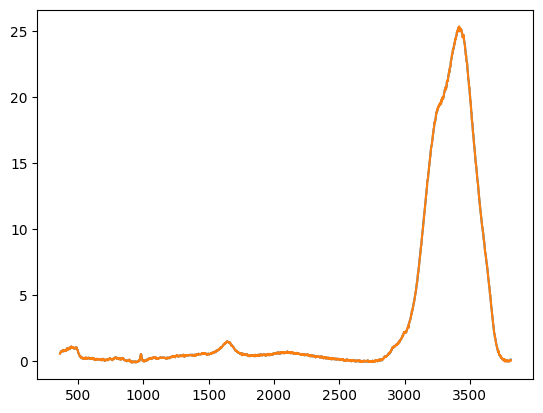

In [31]:
# interpolate the pure water and get values in the datapoints we had in the original data (berofe detrending)

import scipy.interpolate as si

spectrum_spline = si.CubicSpline(x_axis_water, values_water, axis=2, extrapolate=False)
aligned_values_water = spectrum_spline(x_axis)

# align the x axes

# Find the index of the first non-NaN value
first_non_nan_index = np.where(~np.isnan(aligned_values_water))[0][0]

# Find the index of the last non-NaN value
last_non_nan_index = np.where(~np.isnan(aligned_values_water))[0][-1]

print("Index of first non-NaN value:", first_non_nan_index)
print("Index of last non-NaN value:", last_non_nan_index)

x_axis = x_axis[first_non_nan_index:last_non_nan_index+1]
aligned_values_water = aligned_values_water[first_non_nan_index:last_non_nan_index+1]
data = data[:, first_non_nan_index:last_non_nan_index+1]
print(data.shape)

print(aligned_values_water)
print(aligned_values_water.shape)

plt.plot(x_axis, aligned_values_water)
plt.plot(x_axis_water, values_water)
plt.show()

In [32]:
# Calculate the differences so that we get rid of the different height of the spectras

def calculate_differences(spectra):
    differences = np.array([np.diff(spectrum) for spectrum in spectra])
    return differences

differences_spectra = calculate_differences(data)
print(differences_spectra.shape)

differences_water = calculate_differences(aligned_values_water.reshape((1, -1)))
print(differences_water.shape)


(1200, 1528)
(1, 1528)


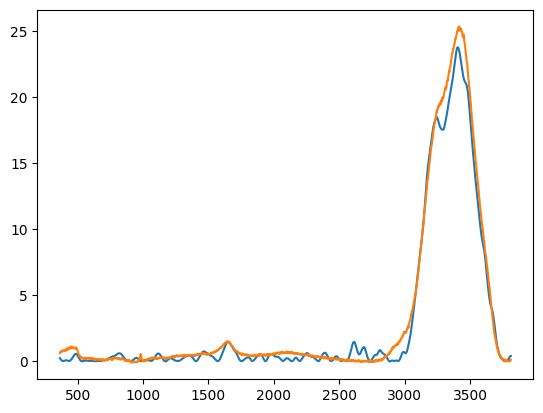

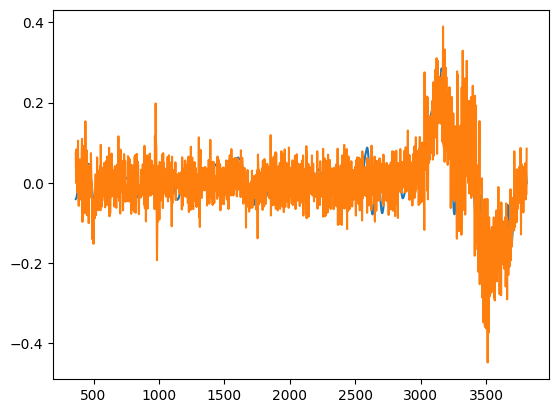

In [33]:
# Visualize spectra
plt.plot(x_axis, data[0])
plt.plot(x_axis, aligned_values_water)
plt.show()

# Visualize diferenced spectra
plt.plot(x_axis[:-1], differences_spectra[0])
plt.plot(x_axis[:-1], differences_water[0])
plt.show()

In [56]:
from numpy import dot
from numpy.linalg import norm
from scipy import spatial

def cosine_similarity(a, b):
    if a.shape != b.shape:
        raise ValueError("The shapes of both arrays must be the same")

    # Compute the norms of each row
    norms_a = norm(a, axis=1)
    norms_b = norm(b, axis=1)

    # Compute the dot product of corresponding rows
    dot_product = np.sum(a * b, axis=1)

    # Calculate cosine similarity
    similarities = dot_product / (norms_a * norms_b)

    return similarities

#distances = np.zeros_like(differences_spectra)

#for spectrum in differences_spectra:
print(data.shape)
print(differences_water.shape)
print(np.tile(differences_water[0], [differences_spectra.shape[0], 1]).shape)
distances = 1 - cosine_similarity(np.tile(differences_water[0], [differences_spectra.shape[0], 1]), differences_spectra) # 1 - to get a distance
# distances = np.array([spatial.distance.cosine(differences_water[0], spectrum) for spectrum in differences_spectra])
print(distances.shape)
print(distances)

(1200, 1529)
(1, 1528)
(1200, 1528)
(1200,)
[0.30460213 0.29055499 0.32286579 ... 0.29764199 0.302463   0.33212153]


198: 0.2711550128679332


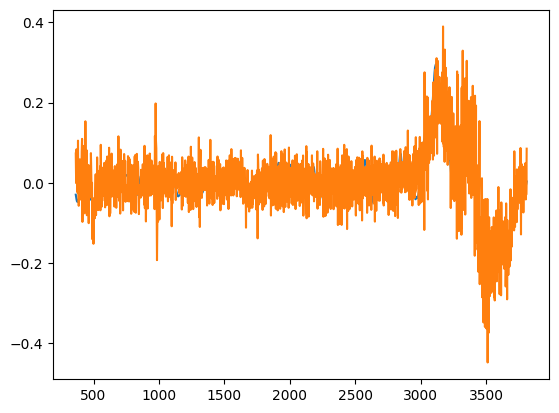

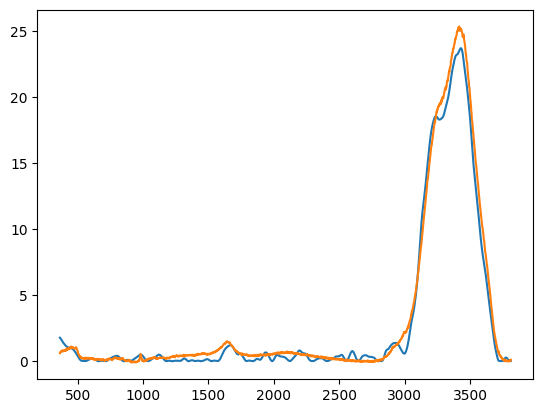

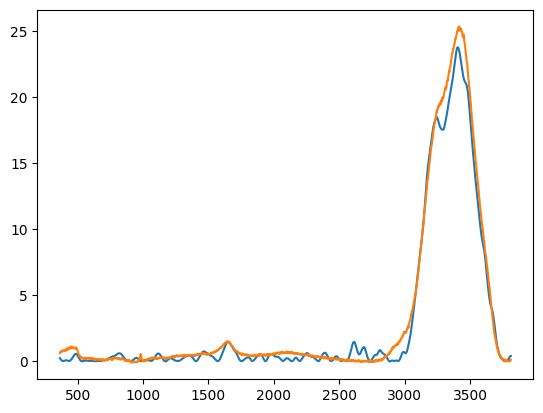

In [60]:
# get closest spectrum to water from orig. data

best_similarity = np.argmin(np.abs(distances)) # abs just to be sure
print(f"{best_similarity}: {distances[best_similarity]}")

plt.plot(x_axis[:-1], differences_spectra[best_similarity])
plt.plot(x_axis[:-1], differences_water[0])
plt.show()

plt.plot(x_axis, data[best_similarity])
plt.plot(x_axis, aligned_values_water)
plt.show()

plt.plot(x_axis, data[0])
plt.plot(x_axis, aligned_values_water)
plt.show()